In [1]:
import pandas as pd

# Load the uploaded files
file_path_eda = "cleaned_data_eda.csv"
file_path_reviews = "reviews_rating_data.csv"

data_eda = pd.read_csv(file_path_eda)
data_reviews = pd.read_csv(file_path_reviews)

# Combine both dataframes for analysis
data_combined = pd.concat([data_eda, data_reviews], axis=0, ignore_index=True)

# Get initial information
data_combined_info = {
    "shape": data_combined.shape,
    "columns": data_combined.columns.tolist(),
    "head": data_combined.head(),
}

data_combined_info


{'shape': (21430, 8),
 'columns': ['nama_produk',
  'harga_produk',
  'penjual',
  'kota_toko',
  'banyak_terjual',
  'rating_produk',
  'Review',
  'Rating'],
 'head':                                          nama_produk  harga_produk  \
 0  sepatu casual sneakers santai terbaru pria tre...      180000.0   
 1  sepatu boots pria gaya baru model fashion tgf2...      275000.0   
 2  Kanky Klasik Story Kagayaku - Sepatu Sneakers ...      388800.0   
 3  Kanky Story Honjo - Sepatu Sneakers Casual Spo...      318800.0   
 4  Aerostreet X Gian 37-44 Putih Biru Tua Oranye ...      229900.0   
 
           penjual        kota_toko  banyak_terjual  rating_produk Review  \
 0  Good Father 40  Jakarta Selatan             5.0            5.0    NaN   
 1  Good Father 40  Jakarta Selatan             4.0            5.0    NaN   
 2    Sepatu Kanky     Kab. Bandung          2000.0            4.9    NaN   
 3    Sepatu Kanky     Kab. Bandung         10000.0            5.0    NaN   
 4      Aerostreet 

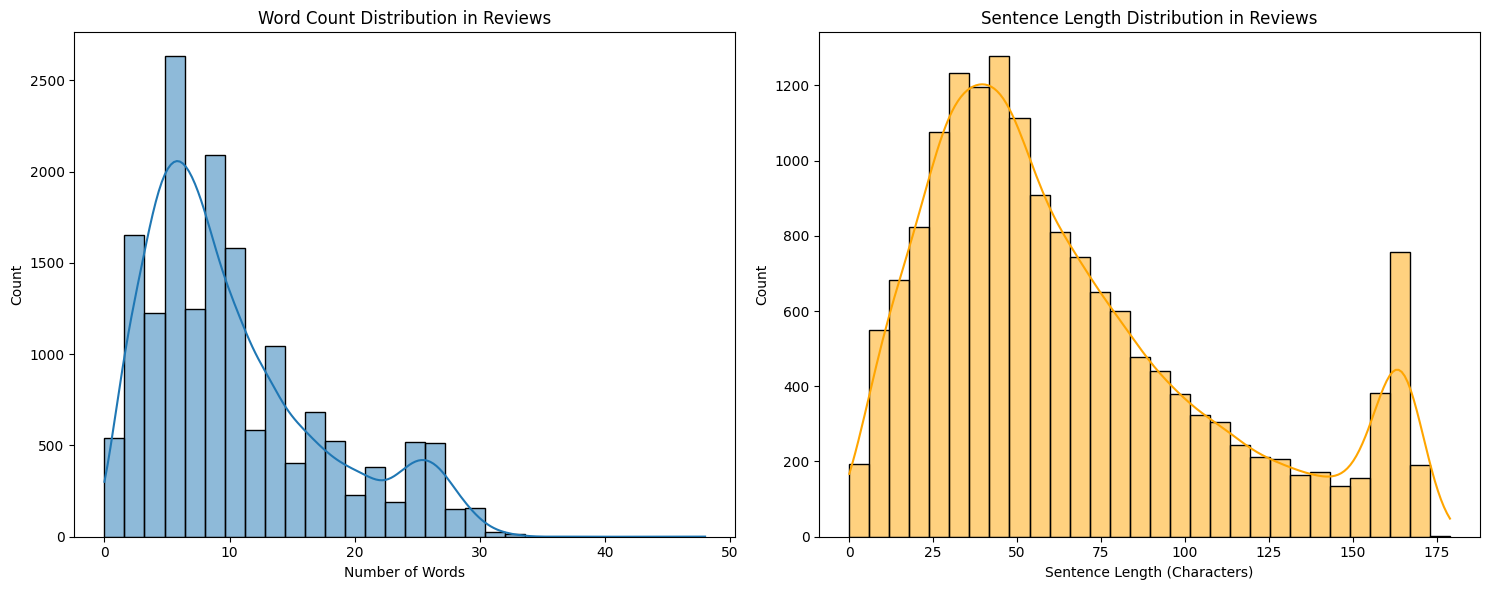

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

# Filter data where reviews exist
data_combined = data_combined.dropna(subset=['Review'])
data_combined = data_combined.drop_duplicates().reset_index(drop=True)

# Define a helper function to clean text
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.lower()  # Convert to lowercase
    return text

# Preprocess reviews
data_combined['Cleaned_Review'] = data_combined['Review'].apply(lambda x: clean_text(str(x)))
data_combined['Word_Count'] = data_combined['Cleaned_Review'].apply(lambda x: len(x.split()))
data_combined['Sentence_Length'] = data_combined['Cleaned_Review'].apply(lambda x: len(x))

# Step 1: Data Overview
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Word Count Distribution
sns.histplot(data_combined['Word_Count'], bins=30, kde=True, ax=ax[0])
ax[0].set_title("Word Count Distribution in Reviews")
ax[0].set_xlabel("Number of Words")
ax[0].set_ylabel("Count")

# Sentence Length Distribution
sns.histplot(data_combined['Sentence_Length'], bins=30, kde=True, ax=ax[1], color='orange')
ax[1].set_title("Sentence Length Distribution in Reviews")
ax[1].set_xlabel("Sentence Length (Characters)")
ax[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


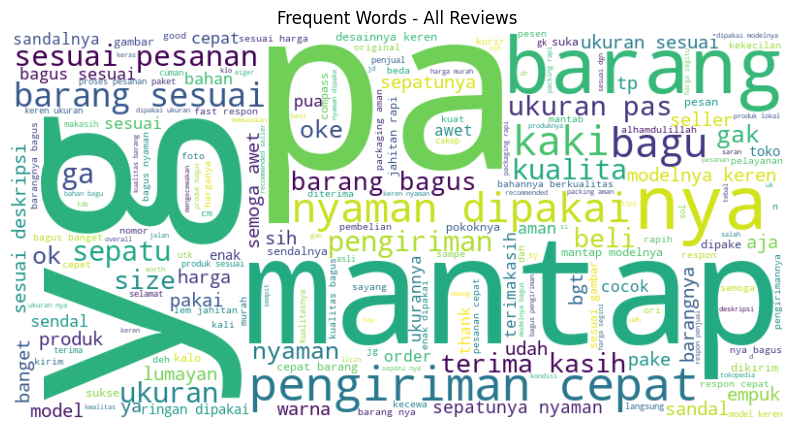

Top 10 Frequent Words:
sesuai: 4173
bagus: 3625
barang: 3249
nyaman: 2473
cepat: 2246
ukuran: 2245
nya: 2076
pas: 1940
pengiriman: 1866
yg: 1705


In [5]:
from sklearn.feature_extraction.text import CountVectorizer

# Define a simple list of Indonesian stopwords manually for this case
manual_stopwords = [
    'yang', 'dan', 'di', 'ke', 'dari', 'untuk', 'ini', 'itu', 'dengan', 'saya', 'kamu', 
    'dia', 'kita', 'mereka', 'ada', 'tidak', 'bisa', 'akan', 'pada', 'oleh', 'sebuah', 'jadi'
]


# Use existing reviews as the dataset does not have rating-based splits
all_reviews = data_combined['Cleaned_Review']

# Generate a word cloud for all reviews (assuming no positive/negative split)
combined_wordcloud = WordCloud(width=800, height=400, stopwords=stop_words, background_color='white').generate(' '.join(all_reviews))

# Vectorize the reviews to find the top N frequent words
vectorizer = CountVectorizer(stop_words=manual_stopwords, max_features=10)
X = vectorizer.fit_transform(all_reviews)

# Get the word frequencies
word_freq = dict(zip(vectorizer.get_feature_names_out(), X.toarray().sum(axis=0)))
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

# Plot Word Cloud
plt.figure(figsize=(10, 6))
plt.imshow(combined_wordcloud, interpolation='bilinear')
plt.title("Frequent Words - All Reviews")
plt.axis('off')
plt.show()

# Display Top N Frequent Words
print("Top 10 Frequent Words:")
for word, freq in sorted_word_freq:
    print(f"{word}: {freq}")


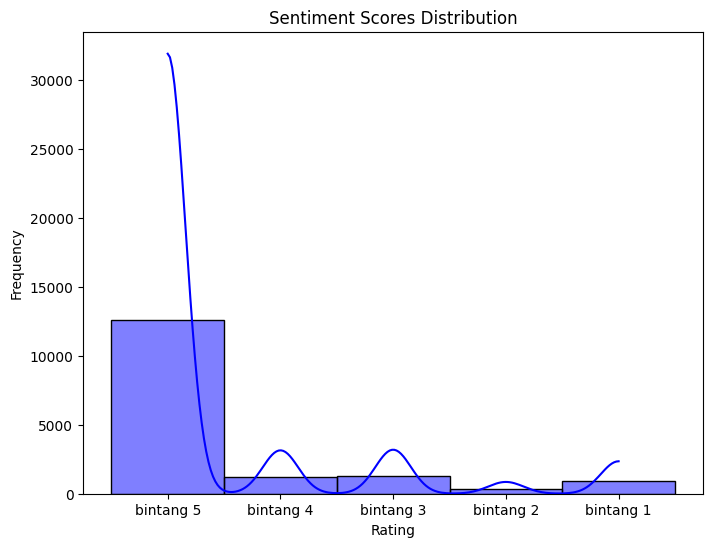

In [7]:
# Check for sentiment scores and ratings in the dataset
# Since 'rating_produk' contains NaN, I'll analyze class balance based on a threshold for 'banyak_terjual' as a placeholder for now

# Define a column for sentiment (simulated sentiment based on 'banyak_terjual')
data_combined['Sentiment'] = data_combined['banyak_terjual'].apply(lambda x: 'Positive' if x >= 50 else 'Negative' if pd.notna(x) else 'Unknown')

# Count sentiment classes
sentiment_counts = data_combined['Sentiment'].value_counts()

# Histogram for Sentiment Scores if they exist (placeholders)
if 'Rating' in data_combined.columns and data_combined['Rating'].notna().sum() > 0:
    plt.figure(figsize=(8, 6))
    sns.histplot(data_combined['Rating'], bins=20, kde=True, color='blue')
    plt.title("Sentiment Scores Distribution")
    plt.xlabel("Rating")
    plt.ylabel("Frequency")
    plt.show()
else:
    "No sentiment score available to visualize."


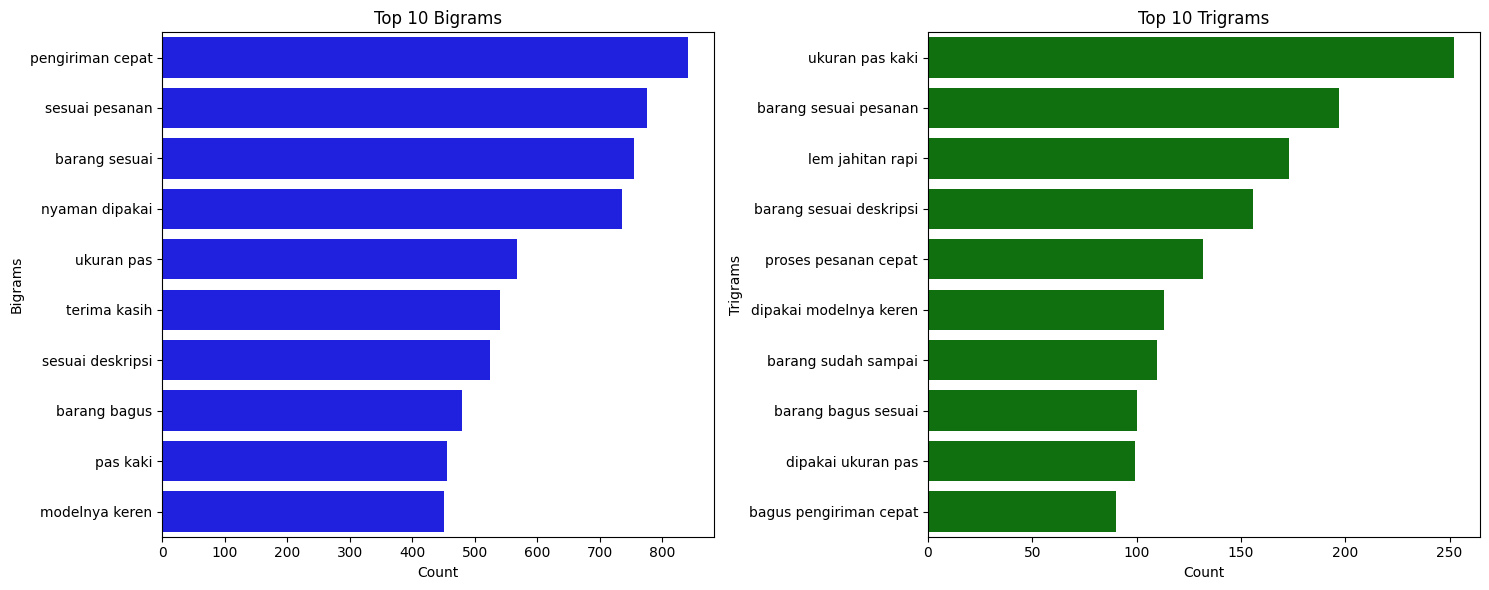

{'Top Positive TF-IDF Words': array(['bagus', 'barang', 'cepat', 'keren', 'nya', 'nyaman', 'pas',
        'pengiriman', 'sesuai', 'ukuran'], dtype=object),
 'Top Negative TF-IDF Words': array(['bagus', 'barang', 'cepat', 'nya', 'nyaman', 'pas', 'pengiriman',
        'sesuai', 'ukuran', 'yg'], dtype=object)}

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Step 1: N-Gram Analysis
def get_top_ngrams(corpus, n=2, top_n=10):
    """ Function to generate top n-grams from text corpus """
    vec = CountVectorizer(ngram_range=(n, n), stop_words=manual_stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    ngram_counts = bag_of_words.sum(axis=0)
    ngrams_freq = [(word, ngram_counts[0, idx]) for word, idx in vec.vocabulary_.items()]
    sorted_ngrams = sorted(ngrams_freq, key=lambda x: x[1], reverse=True)[:top_n]
    return sorted_ngrams

# Get top bigrams and trigrams
top_bigrams = get_top_ngrams(all_reviews, n=2, top_n=10)
top_trigrams = get_top_ngrams(all_reviews, n=3, top_n=10)

# Plot bigrams and trigrams
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Bigrams
bigram_words, bigram_counts = zip(*top_bigrams)
sns.barplot(y=bigram_words, x=bigram_counts, ax=ax[0], color='blue')
ax[0].set_title("Top 10 Bigrams")
ax[0].set_xlabel("Count")
ax[0].set_ylabel("Bigrams")

# Trigrams
trigram_words, trigram_counts = zip(*top_trigrams)
sns.barplot(y=trigram_words, x=trigram_counts, ax=ax[1], color='green')
ax[1].set_title("Top 10 Trigrams")
ax[1].set_xlabel("Count")
ax[1].set_ylabel("Trigrams")

plt.tight_layout()
plt.show()

# Step 2: Unique Word Insights with TF-IDF
# Simulated positive and negative splits
positive_reviews = all_reviews.sample(frac=0.5, random_state=42)
negative_reviews = all_reviews.drop(positive_reviews.index)

# Step 2: Unique Word Insights using TF-IDF
if not positive_reviews.empty and not negative_reviews.empty:
    # TF-IDF for positive reviews
    tfidf_vectorizer_pos = TfidfVectorizer(stop_words=manual_stopwords, max_features=10)
    tfidf_positive = tfidf_vectorizer_pos.fit_transform(positive_reviews)
    positive_words = tfidf_vectorizer_pos.get_feature_names_out()

    # TF-IDF for negative reviews
    tfidf_vectorizer_neg = TfidfVectorizer(stop_words=manual_stopwords, max_features=10)
    tfidf_negative = tfidf_vectorizer_neg.fit_transform(negative_reviews)
    negative_words = tfidf_vectorizer_neg.get_feature_names_out()

    # Display Results
    tfidf_results = {
        "Top Positive TF-IDF Words": positive_words,
        "Top Negative TF-IDF Words": negative_words
    }
else:
    tfidf_results = {"Error": "Insufficient reviews for positive or negative sentiment"}

tfidf_results

